In [1]:
import glob
import datetime
import numpy as np
import pandas as pd
import xarray as xr
import rasterio
import ipywidgets as widgets
import cartopy
import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import utils as utils
from scipy.stats import theilslopes
from ismn.interface import ISMN_Interface
from pytesmo.df_metrics import ubrmsd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%matplotlib inline

# Soil Moisture from passive systems (radiometer)

Satellite radiometers measure emissions in various microwave frequency domains (usually summarized as Ku-, X,- C- and L-band) from the Earth surface as brightness temperature. 

Brightness temperature (in °K) is a function of kinetic temperature and emissivity. Wet soils have a higher emissivity than dry soils and therefore a higher brightness temperature. Passive soil moisture retrieval uses this difference between kinetic temperature and brightness temperature to model the amount of water available in the soil of the observed area, while taking into account factors such as the water held by vegetation (VOD).

$\Large SM \propto T_B$

NASA's SMAP and ESA's SMOS satellites are examples for L-band radiometer missions. They are suitable for retrieving soil moisture globally, even when vegetation is present in a scene.

Different models to retrieve Soil Moisture from brightness temperature exist. One of the them is the Land Parameter Retrieval Model (LPRM) [(Owe et al., 2001)](https://doi.org/10.1109/36.942542). A unique aspect of LPRM is the simultaneous retrieval of vegetation optical depth (VOD) in combination with soil moisture and surface temperature.

The following example gives an overview over the variables that can be retrieved from SMAP brightness temperature observations. The plots show brightness temperature measurements at vertical and horizontal polarization and Surface Temperature, VOD and Soil Moisture derived using the LPRM model.

**Try:**

* **Using the slider to switch between different days of July 2007 and see how the observed patters can change within a month.**

In [2]:
smap_raw = xr.open_dataset('./LTC_DATA/SMAP_raw_202107.nc')
smap_lprm = xr.open_dataset('./LTC_DATA/SMAP_LPRM_202107.nc')

slider=widgets.SelectionSlider(options=np.arange(1,31), value=8, description='Select day in July 2021:', continuous_update=False, style={'description_width': 'initial'})
@widgets.interact(day=slider)
def plot_lprm(day):
    """
    Select and visualise SMAP data at a given time
    """
    date = f'2021-07-{day:02}'
    
    fig, axs = plt.subplots(1, 2, figsize=(15,3), subplot_kw={'projection': ccrs.Robinson()})
    p1 = smap_raw['tbh'].sel(time=date).plot(transform=ccrs.PlateCarree(), ax=axs[0],  cmap=plt.get_cmap('gist_yarg'), vmin=200, vmax=320, cbar_kwargs={'label': '[°K]'})
    axs[0].set_title(f"{date} " "$T_{B,H}$")
    p2 = smap_raw['tbv'].sel(time=date).plot(transform=ccrs.PlateCarree(), ax=axs[1],  cmap=plt.get_cmap('gist_yarg'), vmin=200, vmax=320, cbar_kwargs={'label': '[°K]'})
    axs[1].set_title(f"{date} " "$T_{B,V}$")
                
    for p in [p1, p2]:
        p.axes.coastlines()
        
    fig, axs = plt.subplots(1, 3, figsize=(18,3), subplot_kw={'projection': ccrs.Robinson()})
    
    p3 = smap_lprm['temperature'].sel(time=date).plot(transform=ccrs.PlateCarree(), ax=axs[0], cmap=plt.get_cmap('hot_r'), vmin=274, vmax=320, cbar_kwargs={'label': '[°K]'})
    axs[0].set_title(f"{date} Surface Temperature")
    
    p4 = smap_lprm['vod'].sel(time=date).plot(transform=ccrs.PlateCarree(), ax=axs[1], cmap=plt.get_cmap('Greens'), vmin=0, vmax=0.5, cbar_kwargs={'label': '[-]'})
    axs[1].set_title(f"{date} Vegetation Optical Depth")
    
    p5 = smap_lprm['soil_moisture'].sel(time=date).plot(transform=ccrs.PlateCarree(), ax=axs[2], cmap=utils.cm_sm, vmin=0, vmax=0.5, cbar_kwargs={'label': '[m³/m³]'})
    axs[2].set_title(f"{date} Soil Moisture")
            
    for p in [p3, p4, p5]:
        p.axes.add_feature(cartopy.feature.LAND, zorder=0, facecolor='gray')
        p.axes.coastlines()
        
    plt.tight_layout()
    

interactive(children=(SelectionSlider(continuous_update=False, description='Select day in July 2021:', index=7…

# Soil Moisture from Synthetic Aperture Radar (CGLS)
The Copernicus Global Land Service Surface Soil Moisture dataset is a NRT 1km dataset based on Sentinel-1 observations. It is available through https://land.copernicus.eu/global/products/ssm as daily netCDF or TIFF files. 

For this exercise we downloaded TIFF files of SSM for the period 2018-2020 over a region in northern Italy. Code is provided to read plot spatial images and extract time series comparing it to in situ soil moisture.

### Reading and stacking SSM data
xarray is very powerful for reading multiple files of netCDF or geotiff. We use here open_mfdataset with a list of filepaths to read the stack. One disadvantage is that time information is not included in this reading function. The files are sorted according to date with the dataframe df, which includes the timestamps as index. 

In [3]:
filelist=glob.glob('./LTC_DATA/CGLS_SSM/c_gls_SSM1km-ssm_*.tiff')
dt=[datetime.datetime.strptime(x.split('/')[-1].split('_')[-4], '%Y%m%d%H%M') for x in filelist]
df = pd.DataFrame({'filepath':filelist}, index=dt).sort_index()
stack = xr.open_mfdataset(df.filepath.values, engine='rasterio', chunks={}, combine='nested', concat_dim='time')
dslon = stack['x'].compute()
dslat = stack['y'].compute()
ssm = stack['band_data'].compute()

### Plotting monthly means 
Plotting monthly anomalies can be done easily from a numpy array. We convert the data to a numpy array and can index the data for the selected months using the dataframe df.  

**Try:**

* **Plotting monthly anomalies for other time periods, such as the drought in 2022**

/tmp/ipykernel_12296/2985532873.py:31: RuntimeWarning: Mean of empty slice
  sm_mean=np.nanmean(sm_data,axis=0)


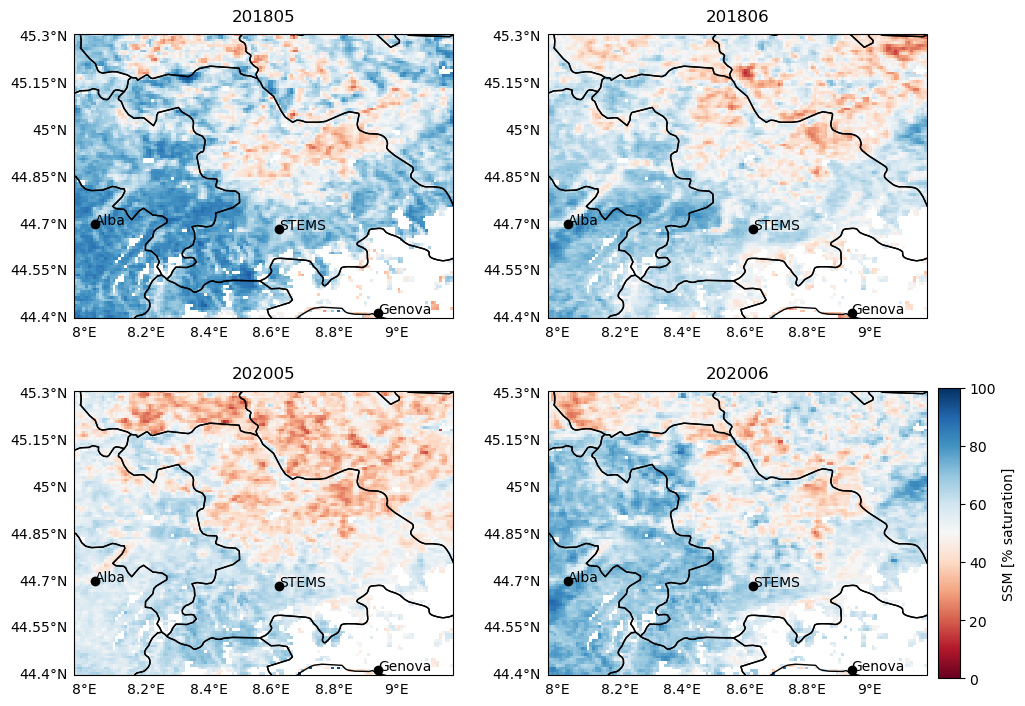

In [4]:
#select dates (YYYYMM) to calculate monthly mean over. 
dates=['201805','201806','202005','202006']
cities = {'Alba':[8.0347, 44.6999 ], 'Genova':[8.942184, 44.414165], 'STEMS':[8.62641,44.68253] }
fig, axs = plt.subplots(nrows=2,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(11,8.5), sharex=True, sharey=True)
img_extent=[dslon.min(), dslon.max(), dslat.min(), dslat.max()] #set the extent of your data
for dts, ax in zip(dates, axs.flatten()):
    idx=(df.index.year==int(dts[:4]))&(df.index.month==int(dts[4:6])) #index months
    ax.set_title(dts) #set title of subplot
    
    #we include some cities and the location of the ISMN STEMS network in the map for clarity 
    #this is a work-around to transform xy coords in ax.annotate
    transform_mpl = ccrs.PlateCarree()._as_mpl_transform(ax) 
    for city in cities:
        ax.scatter(cities[city][0],cities[city][1], marker='o', c='black')
        ax.annotate(city, cities[city], xycoords=transform_mpl)
    
    #set extent of the map, show gridlines and a province boundaries
    ax.set_extent(img_extent)
    ax.add_feature(cartopy.feature.NaturalEarthFeature('cultural', 'admin_1_states_provinces', '10m'),
                   zorder=2,facecolor='none')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                       alpha=0.0)
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    sm_data= ssm[idx,:,:].to_numpy()
    sm_data[sm_data>100]=np.NaN
    sm_mean=np.nanmean(sm_data,axis=0)
    #plot the data
    sc = ax.imshow(sm_mean.squeeze(), origin='upper', extent=img_extent,
                       vmin=0, vmax=100, cmap='RdBu', interpolation='none')

#add colorbar
cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0,
                    0.02, ax.get_position().height])

cbar = fig.colorbar(sc, ax=ax, cax=cax)
cbar.set_label('SSM [% saturation]')
plt.subplots_adjust(wspace=0.25)

### Time series 
To read time series we need to find the closest gridpoint to different longitudes and latitudes. xarray stack allows to find the closest gridpoint to your latitude and longitude using the .sel function. Below is an example for the ISMN STEMS network where four soil moisture stations are located. Note: using the ismn package will be explained later. 

/tmp/ipykernel_12296/1229424994.py:21: RuntimeWarning: Mean of empty slice
  sc = ax.imshow(np.nanmean(ssm[idx,:,:],axis=0)[0], origin='upper', extent=img_extent,


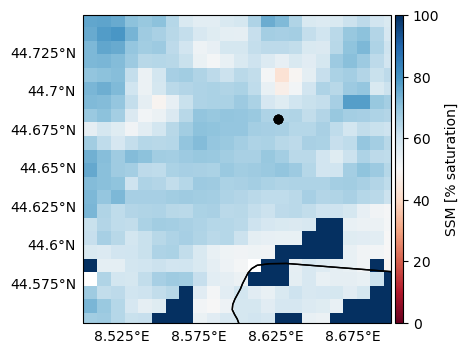

In [5]:
stations=['CAN_CT_NT', 'CAN_CT_T','CAN_GC_NT','CAN_GC_T']
lons=[8.62641, 8.62639, 8.6267, 8.62669] 
lats=[44.68253, 44.68253, 44.68278, 44.68277]
fig, ax = plt.subplots(nrows=1,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(4,4), sharex=True, sharey=True)
img_extent=[dslon.min(), dslon.max(), dslat.min(), dslat.max()]

transform_mpl = ccrs.PlateCarree()._as_mpl_transform(ax) #this is a work-around to transform xy coords in ax.annotate
for station, lon ,lat in zip(stations, lons,lats):
    ax.scatter(lon,lat, marker='o', c='black')
ax.add_feature(cartopy.feature.NaturalEarthFeature('cultural', 'admin_1_states_provinces', '10m'),zorder=2,facecolor='none')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                   alpha=0.0)
ax.set_extent([8.5, 8.7, 44.55,44.75])
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
# todo: @mariette I changed the next line slightly
sc = ax.imshow(np.nanmean(ssm[idx,:,:],axis=0)[0], origin='upper', extent=img_extent,
                   vmin=0, vmax=100, cmap='RdBu', interpolation='none')
cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0,
                    0.02, ax.get_position().height])
cbar = fig.colorbar(sc, ax=ax, cax=cax)
cbar.set_label('SSM [% saturation]')

The stations all fall within the same station, which means we have in this case four time series that are exactly the same. The time series can be viewed easily by creating a dataframe 
We will use this dataframe later in combination with ISMN data. 

<AxesSubplot:ylabel='SSM [% saturation]'>

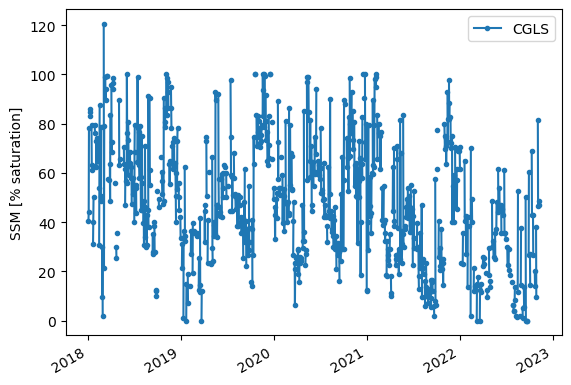

In [6]:
cgls_sm = pd.DataFrame(index=df.index)

cgls_sm.loc[:, 'CGLS'] = ssm.sel(x=8.62641, y=44.68253, method='nearest')
cgls_sm.plot(marker='.',ylabel='SSM [% saturation]')

# Merged Soil Moisture products: ESA CCI & C3S Soil Moisture
Single-sensor products like the ones above are limited by the life time of the satellite sensors. Climate change assessments, however, require the use of long-term data records, that span over multiple decades and provide consistent and comparable observations. The ESA CCI Soil Moisture record therefore merges the observations from more than 15 sensors into one harmonized record. The main 2 steps of the product generation include scaling all sensors to a common reference, and subsequently merging them by applying a weighted average, where sensor with a lower error are assigned a higher weight.

<img src="img/cci_sensors.png" width="50%"/>

You can try something similar yourself in the next cell. There you find the soil moisture time series for three different sensors (Metop-A ASCAT, Aqua AMSR-E, and SMOS Miras) for a point in Hungary (Lon: 18.65 °E, Lat: 48.875 °N). As you can see, there are various differences between the sensor time series (due to different instrument type, measurement frequency, footprint size, overpass time, ...). By changing the scaling parameters above the plot for each sensor, you can try to match them to each other. `shift` here means adding an (additive) offset to the time series (changing the mean), while `scale` means multiplying the time series with the chosen factor.

**Try:**

* **Scaling the 3 sensors to each other to create a harmonized time series.**


In [7]:
df = pd.read_csv('./LTC_DATA/sensors_hun_18.65_48.875.csv', index_col=0, parse_dates=True)

@widgets.interact(
ascat_add=widgets.FloatSlider(value=0, min=-50, max=50, step=1, description='ASCAT shift', style={'description_width': 'initial'}),
ascat_mult=widgets.FloatSlider(value=1, min=0.1, max=2, step=0.05, description='ASCAT scale', style={'description_width': 'initial'}),
amsre_add=widgets.FloatSlider(value=0, min=-50, max=50, step=1, description='AMSR-E shift', style={'description_width': 'initial'}),
amsre_mult=widgets.FloatSlider(value=1, min=0.1, max=2, step=0.05, description='AMSR-E scale', style={'description_width': 'initial'}),
smos_add=widgets.FloatSlider(value=0, min=-50, max=50, step=1, description='SMOS shift', style={'description_width': 'initial'}),
smos_mult=widgets.FloatSlider(value=1, min=0.1, max=2, step=0.05, description='SMOS scale', style={'description_width': 'initial'}),
continuous_update=False)
def scale(ascat_add, ascat_mult, amsre_add, amsre_mult, smos_add, smos_mult):
    df['ascat_scaled'] = (df['ascat'] - df['ascat'].mean()) * ascat_mult + (df['ascat'].mean() + ascat_add)
    df['amsre_scaled'] = (df['amsre'] - df['amsre'].mean()) * amsre_mult + (df['amsre'].mean() + amsre_add)
    df['smos_scaled'] = (df['smos'] - df['smos'].mean()) * smos_mult + (df['smos'].mean() + smos_add)
    
    df[['ascat_scaled', 'amsre_scaled', 'smos_scaled']].plot(figsize=(10,3), title='Sensor scaling', ylabel='Soil Moisture', xlabel='time')


interactive(children=(FloatSlider(value=0.0, description='ASCAT shift', max=50.0, min=-50.0, step=1.0, style=S…

By combining all >15 available sensors we can create a global data set that spans over many decades. The Copernicus Climate Change Service (C3S) applies the ESA CCI Soil Moisture algorithm to a set of historic and operational sensors, and therefore can provide a harmonised record with only a few days delay after taking the measurements. However, the data coverage still depends on the number of available satellites each day. While nowadays many sensors from different space agencies collect and distribute data, there were fewer satellites available in the 1980s and 1990s.

The following cell lets you plot annual average soil moisture from the C3S data set. In the right subplot you can see for how many days in the chosen year at least one observation was available (from any of the sensors).

**Try:**

* **Changing the year and see how the soil moisture and data density is affected**
* **Finding permanent gaps in the record and patterns in data coverage**
* **You can also view anomalies, which are an indicator for drier/wetter than usual conditions in a region.**

In [8]:
c3s_annual = xr.open_dataset('./LTC_DATA/C3S_v202012_COMBINED_annual.nc')

@widgets.interact(year=widgets.SelectionSlider(options=np.arange(1978, 2022), value=2021, description='Select a year to plot:', continuous_update=False, 
                                               style={'description_width': 'initial'}))
def plot_soil_moisture(year: int, Anomalies: bool = False):
    """
    Select and visualise C3S SM data at a given time
    """
    if Anomalies:
        var = 'sm_anom'
        kwargs = dict(cmap=plt.get_cmap("RdBu"), vmin=-0.1, vmax=0.1)
    else:
        var = 'sm'
        kwargs = dict(cmap=utils.cm_sm, vmin=0, vmax=0.5)

    label_sm = f"Soil Moisture{' Anomaly ' if Anomalies else ' '}$[m^3m^{-3}]$"    
        
    fig, axs = plt.subplots(1, 2, figsize=(20,4), subplot_kw={'projection': ccrs.Robinson()})
    
    # Select and plot the soil moisture data
    p1 = c3s_annual[var].sel(year=year).plot(transform=ccrs.PlateCarree(), ax=axs[0], cbar_kwargs={'label': label_sm}, **kwargs)
    axs[0].set_title(f"{year} - Annual average {'soil moisture' if not Anomalies else 'soil moisture anomalies'}")
    
    # Select and plot the coverage data
    p2 = c3s_annual['nobs'].sel(year=year).plot(transform=ccrs.PlateCarree(), ax=axs[1], vmax=366, vmin=0, cmap=plt.get_cmap('YlGnBu'), 
                                                cbar_kwargs={'label': 'Days with valid observations'})
    axs[1].set_title(f"{year} - Data coverage")
    
    for p in [p1, p2]:
        p.axes.add_feature(cartopy.feature.LAND, zorder=0, facecolor='gray')
        p.axes.coastlines()

interactive(children=(SelectionSlider(continuous_update=False, description='Select a year to plot:', index=43,…

# Time series extraction and analysis
For many studies we are interested in looking at soil moisture time series. One example for this would be the assessment of long-term changes in the data (**trends**). The following example shows how we extract a time series at a given location from the monthly stack of C3S soil moisture values and compute the annual change of the chosen time range.

**Try:**

* **Choosing a different point in the study area - Longitude between -10 and 40 degrees, Latitude between 30 and 70 degrees; point must be over land) to extract the data for**
* **See how the trend changes for different locations and time periods**

In [9]:
c3s_europe = xr.open_dataset('./LTC_DATA/STACK_C3S-SOILMOISTURE_EUROPE_v202012_PASSIVE_MONTHLY.nc')
extracted_ts = dict()

slider=widgets.IntRangeSlider(min=1979, max=2021, value=[1991, 2021], step=1, description='Time Range:', continuous_update=False)
@widgets.interact(period=slider, Longitude="8.625", Latitude="44.625")
def extract_ts(period, Longitude, Latitude):
    var = 'sm'  # or sm_anom
    lon, lat = float(Longitude), float(Latitude)
    
    # Extract time series at location
    ts = c3s_europe.sel(lon=lon, lat=lat, method='nearest').to_pandas() \
                   .loc[f"{period[0]}-01-01":f"{period[1]}-12-31", [var]]
    
    # Set up figures
    fig = plt.figure(figsize=(15,4), constrained_layout=True)
    gs = fig.add_gridspec(1, 3)
    map_ax = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
    ts_ax = fig.add_subplot(gs[0, 1:])

    # Plot overview map
    map_ax.set_extent([-14, 46, 29, 71])
    map_ax.add_feature(cartopy.feature.LAND, zorder=0)
    map_ax.add_feature(cartopy.feature.BORDERS)
    map_ax.coastlines()
    map_ax.plot([lon], [lat], 'ro', transform=ccrs.PlateCarree())
    map_ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    
    # Compute trend from annual averages
    medslope, medinter, _, _ = theilslopes(ts.resample('A').mean().bfill().ffill().values)
    ts['trend'] = medinter + np.arange(len(ts.index.values)) * (medslope / 12)
    
    # Plot time series and trend
    ts[var].plot(style='-o', ax=ts_ax, label='soil moisture')
    ts['trend'].plot(style='-', color='red', ax=ts_ax, label=f'{medslope:.4f} [m³/m³/year]')
    ts_ax.set_xlabel('Time [Year]')
    ts_ax.set_ylabel('SM $[m³/m³]$')
    ts_ax.set_title(f'Soil Moisture and Trend at Lon: {lon}°, Lat: {lat}°')
    ts_ax.legend()
    
    # Make data available for the next example
    global extracted_ts
    extracted_ts = dict(data=ts.copy(), lon=lon, lat=lat)

interactive(children=(IntRangeSlider(value=(1991, 2021), continuous_update=False, description='Time Range:', m…

# In situ soil moisture and satellite validation
Until now we have only looked at satellite based soil moisture measurements. However, soil moisture is also measured at ground stations of insitu networks.
Station measurements are an important tool to understand the behaviour of soil moisture. They help us improve the models to derive data from satellite measurements, and we can use these data to verify our satellite records.

In the next example we read in situ soil moisture measurements and compare them to each other and to the C3S time series they are located in. The data comes from the [**International Soil Moisture Network (ISMN)**](https://ismn.earth/en/), who collect, review, reformat and finally distibute data from various networks around the globe.

<img src="img/ismn.png" width="50%"/>

In the next example we use in situ data from the "STEMS" network in North-West Italy (see map). The network consists of 2 station pairs ('CAN-CT' and 'CAN-GC'), which are ~50 metres apart. There are 2 stations at each location where up to 5 sensors measure soil moisture in different depths between 0.1 and 0.5 metres. We therefore have up to 15 insitu time series that we can use.

**Try:**

* **Reading in situ data for different depths at the stations**
* **Think about why there are differences between these time series, and how they are related to the depths of the sensors**
* **Choose a range of in situ sensors that you think can be compared to the satellite data in the same area**

<font color='red'>**Note: The sensors you finally choose here will be used in the next example**</font>

In [14]:
request = OSM()

ismn = ISMN_Interface("./LTC_DATA/insitu")
stems = None

@widgets.interact(depth=widgets.FloatRangeSlider(min=0., max=0.5, value=[0., 0.5], step=0.1, description='Depth:', continuous_update=False))
def read_ismn(depth):
    min_depth, max_depth = depth

    fig = plt.figure(figsize=(15,4), constrained_layout=True)
    gs = fig.add_gridspec(1, 3)
    map_ax, ts_ax = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree()), fig.add_subplot(gs[0, 1:])
    
    # Plot a small overview map with station locations over Open Street Map
    ismn.plot_station_locations(variable='soil_moisture', min_depth=min_depth, max_depth=max_depth, markersize=10, text_scalefactor=2, stats_text=True, ax=map_ax)
    map_ax.set_extent([6,14,41,47])
    map_ax.add_image(request, 6)

     # Extract the sensors in the chosen depths at the locations and store their data
    sensors = []
    for network, station, sensor in ismn.collection.iter_sensors(variable='soil_moisture', depth=(min_depth, max_depth)):
        data = sensor.read_data()
        data.loc[data['soil_moisture_flag'] != 'G', 'soil_moisture'] = np.nan
        data = data['soil_moisture']
        if sensor.depth[0] == sensor.depth[1]:
            depth = f"{sensor.depth[0]}"
        else:
            depth = f"{sensor.depth[0]}-{sensor.depth[1]}"
        data.name = f"{station.name} ({depth} m)"
        sensors.append(data)
    
    global stems
    stems = pd.concat(sensors, axis=1).loc['2017-01-01':,:]
    
    p = stems.plot(ax=ts_ax, xlabel='time', ylabel='SM [m³/m³]', title=f'Insitu data at STEMS network ({min_depth} to {max_depth} [m] depth)')
    p.legend(fontsize="x-small")


Found existing ismn metadata in LTC_DATA/insitu/python_metadata/insitu.csv.


interactive(children=(FloatRangeSlider(value=(0.0, 0.5), continuous_update=False, description='Depth:', max=0.…

Using the data from the previous example, we can now check how the insitu time series correspond with each other. 

We compute the correlation coefficient (R) 

$\Large R=\frac{\sum_{i=1}^{n}(x_i-\bar{x})(y_i-\bar{y}) }{\sqrt{\sum_{i=1}^{n}(x_i-\bar{x})^2}\sqrt{\sum_{i=1}^{n}(y_i-\bar{y})^2}}$

and BIAS

$\Large BIAS=\bar{x} -\bar{y}$

between each sensor pair and visualize them as a heat map (note that the number of entries is affected by the chosen sensor range in the above example).

**Try:**

* **Changing the range of insitu probes in the previous example, and see how it affects the metrics when running this cell.**
* **Spotting patterns in the created heat maps, what are the reasons? Consider differences in the station locations (see their names) and their depth.**
* **Finding sensors that look suspicious as they don't fit to any other sensors.**

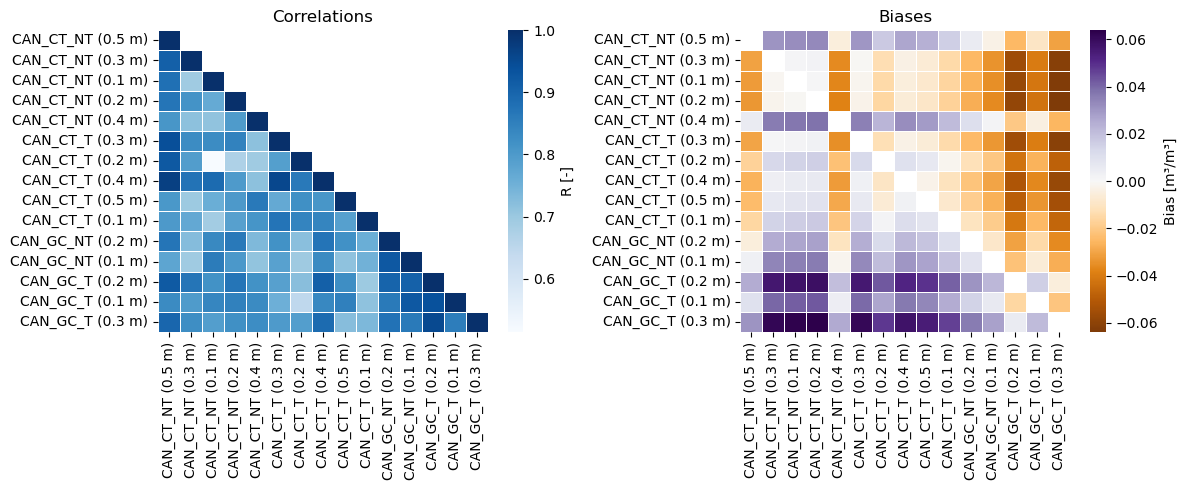

In [15]:
import seaborn as sns
import itertools

corr = stems.corr()

permutations = [c for c in itertools.permutations(stems.columns, 2)]
bias = pd.DataFrame(index=stems.columns, columns=stems.columns, data=np.nan)
for c1, c2 in permutations:
    bias.loc[c1, c2] = stems[c1].mean() - stems[c2].mean()

mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

fig, axs = plt.subplots(1,2, figsize=(12,5))
p1 = sns.heatmap(corr, mask=mask, cmap=plt.get_cmap('Blues'), vmax=1, linewidths=0.5, ax=axs[0],
                cbar_kws={'label': 'R [-]'})
p1.set_title('Correlations')

p2 = sns.heatmap(bias, cmap=plt.get_cmap('PuOr'), linewidths=0.5, ax=axs[1],
                 cbar_kws={'label': 'Bias [m³/m³]'})
p2.set_title('Biases')
fig.tight_layout()

Finally we compute correlation coefficients between satellite observations and insitu data. We use a daily time series here. The satellite data is matched to the daily averaged insitu values upon loading.

We see that the correlation varies for different probes, but is generally higher with in situ sensors in the top layer.

**Try:**

* **Changing the range of in situ probes in the previous example, and see how it affects the metrics when running this cell.**

<AxesSubplot:title={'center':'Correlation with satellite observations'}, ylabel='R[-]'>

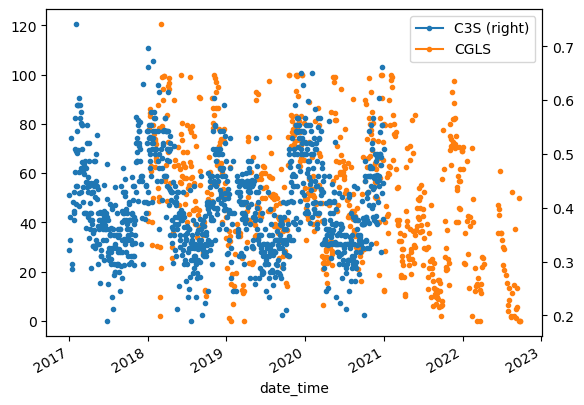

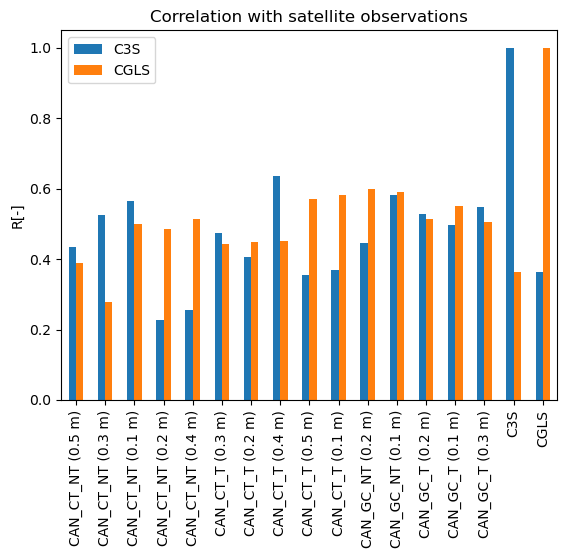

In [17]:
stems['C3S'] = pd.read_csv("./LTC_DATA/C3S_PASSIVE_TS_ITALY_8_625_44_625_daily.csv", index_col=0, parse_dates=True).loc['2017-01-01':, 'sm']
cgls_sm = cgls_sm[~cgls_sm.index.duplicated()]
stems['CGLS'] = cgls_sm
stems[['C3S','CGLS']].plot(marker='.', secondary_y='C3S')
# we take the daily averages of the insitu (and satellite data) and present correlations as a bar plot
stems.resample('D').mean().corr()[['C3S', 'CGLS']].plot.bar(rot=90, ylabel='R[-]', title='Correlation with satellite observations')

## Satellite soil moisture validation with QA4SM

Large-scale quality assessments of daily observations are computationally demanding. While it often can be done in a script like the one above, it is important to apply standardized methods and provide traceable results. Within ESA's FRM4SM project, an online validation tool called **QA4SM** was developed. The goal is to provide a standardized framework to assess the quality of different satellite soil moisture products to insitu and model soil moisture values.

<img src="img/qa4sm_box.png" width="30%"/> <img src="img/qa4sm_map.png" width="50%"/>

You can find the validation above (C3S compared to ISMN) here: https://qa4sm.eu/ui/validation-result/e2bd5827-0560-46db-969e-6a2220ad4cc2

As the spatial distribution of insitu probes varies strongly for different continents, we often also compare satellite soil moisture data to reanalyses and models to get a gap-free estimate of the data quality. However, low correlation values in this case can often also be due to errors in the model, rather than the satellite observations, which must be taken into account.

<img src="img/qa4sm_map_era5.png" width="50%"/>

You can find he validation above (C3S compared to ERA5-Land) here: https://qa4sm.eu/ui/validation-result/cf26befd-d356-4636-97d9-83438a586995

**Try:**

* **Browsing throught the validation runs above between ISMN, ERA5 and C3S SM.**
* **Setting up an account at https://qa4sm.eu/ and run a validation of a satellite against ISMN or any other data set.**

# Outlook on drought assessments
An important field of application for soil moisture data sets is the assessment of droughts, their impact on agricultural yield and their prediction. There is a separate lecture on this topic. However, using the satellite data from the previous examples, here we compute anomalies for different European countries. The plots show how droughts can be observed from space using satellite data sets such as the C3S soil moisture data.

**Try:**

* **Changing the year and study area to plot soil moisture anomalies for.**
* **Finding patterns in the data, explaining outliers or data gaps.**

In [13]:
mask = xr.open_dataset('./grid_eu.nc')['country'].sortby('lat', ascending=False)
lut = dict(zip(mask.attrs['flag_meanings'], mask.attrs['flag_values']))

def load_study_area(country, var='sm', time_from='2010-01-01'):
    subset = c3s_europe.sel(time=slice(time_from, None))[var]
    sel = mask.where(mask==lut[country], drop=True)
    subset = subset.sel(lat=sel.lat, lon=sel.lon)
    subset.values[:, ~np.isfinite(sel)] = np.nan
    return subset

country_data = dict()

dropdown = widgets.Dropdown(options=utils.europe_countries, value='Italy',description='Country:')
slider = widgets.SelectionSlider(options=np.arange(2010,2022), value=2021, description='Select a year:', continuous_update=False)
@widgets.interact(year=slider, country=dropdown)
def plot_months(year=2021, country='Italy'):
    global country_data
    
    if not (country in country_data.keys()):
        country_data = {country: load_study_area(country, var='sm_anom')}

    dat = country_data[country].sel(time=slice(f'{year}-01-01', f'{year}-12-31'))
    p = dat.plot(transform=ccrs.PlateCarree(),
                 col='time', col_wrap=None if year == 2022 else 6, vmin=-0.2, vmax=0.2, cmap=plt.get_cmap('RdBu'),
                 subplot_kws={'projection': ccrs.PlateCarree()})
    for ax in p.axs.flat:
        ax.axes.add_feature(cartopy.feature.BORDERS, linewidth=0.5, zorder=2)        
        ax.axes.coastlines()


interactive(children=(SelectionSlider(continuous_update=False, description='Select a year:', index=11, options…